### Twitter Data Analysis


In [1]:
import os
from fnmatch import fnmatch
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import spacy
import glob
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import datetime
import re
from nltk.corpus import stopwords
from nltk import bigrams
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
import itertools
import collections
import plotly.express as px
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [3]:
filename=[]
root = '../data/'
pattern = "*.csv"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            filename.append(os.path.join(path, name))

In [4]:
data = pd.concat( [ pd.read_csv(file) for file in filename ] )
data.reset_index(inplace=True)


In [5]:
data.head()

,index,date,tweet,word
0,0,2019-01-20 23:04:24+00:00,Logitech Prodigy G213 Gaming Keyboard [50% dis...,amazonindia
1,1,2019-01-20 22:47:26+00:00,Can you guys (whoever's reading this) dm @/Ama...,amazonindia
2,2,2019-01-20 22:04:27+00:00,Artis E400M in-Ear Headphones with Mic (Black)...,amazonindia
3,3,2019-01-20 21:24:51+00:00,@JeffBezos called Amazon India to report an in...,amazonindia
4,4,2019-01-20 21:04:30+00:00,TP-Link HA100 NFC-Enabled Bluetooth Music Rece...,amazonindia


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45144 entries, 0 to 45143
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   45144 non-null  int64 
 1   date    45144 non-null  object
 2   tweet   45143 non-null  object
 3   word    45144 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [7]:
data['Date'] = [datetime.datetime.fromisoformat(x).date() for x in data['date']]
data.drop(['date','index','word'],axis=1,inplace=True)

In [8]:
data.head()

,tweet,Date
0,Logitech Prodigy G213 Gaming Keyboard [50% dis...,2019-01-20
1,Can you guys (whoever's reading this) dm @/Ama...,2019-01-20
2,Artis E400M in-Ear Headphones with Mic (Black)...,2019-01-20
3,@JeffBezos called Amazon India to report an in...,2019-01-20
4,TP-Link HA100 NFC-Enabled Bluetooth Music Rece...,2019-01-20


In [9]:
# Making text lower case
data['tweet'] = [str(x).lower() for x in data['tweet']]

#Removing stop words and punctuation, hyperlinks
# def remove_url(txt):
#     return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)

    return no_url

# def form_sentence(tweet):
#     tweet_blob = TextBlob(tweet)
#     return ' '.join(tweet_blob.words)
# data['cleaned_tweets'] = [form_sentence(str(x))  for x in data['tweet']]

data['cleaned_tweet'] = [remove_url(str(x)) for x in data['tweet']]
data['cleaned_tweet'] = [re.sub('[^A-z0-9 # @ %]', '', x) for x in data['cleaned_tweet']]

In [10]:
data['words_in_tweet' ]= [tweet.lower().split() for tweet in data['cleaned_tweet']]

In [11]:
data.head()

,tweet,Date,cleaned_tweet,words_in_tweet
0,logitech prodigy g213 gaming keyboard [50% dis...,2019-01-20,logitech prodigy g213 gaming keyboard [50% dis...,"[logitech, prodigy, g213, gaming, keyboard, [5..."
1,can you guys (whoever's reading this) dm @/ama...,2019-01-20,can you guys whoevers reading this dm @amazonh...,"[can, you, guys, whoevers, reading, this, dm, ..."
2,artis e400m in-ear headphones with mic (black)...,2019-01-20,artis e400m inear headphones with mic black [5...,"[artis, e400m, inear, headphones, with, mic, b..."
3,@jeffbezos called amazon india to report an in...,2019-01-20,@jeffbezos called amazon india to report an in...,"[@jeffbezos, called, amazon, india, to, report..."
4,tp-link ha100 nfc-enabled bluetooth music rece...,2019-01-20,tplink ha100 nfcenabled bluetooth music receiv...,"[tplink, ha100, nfcenabled, bluetooth, music, ..."


In [12]:
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*data['words_in_tweet']))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)


In [13]:
# Getting top 20 words
clean_tweets_no_urls = pd.DataFrame(counts_no_urls.most_common(20),
                             columns=['words', 'count'])

clean_tweets_no_urls.head()

,words,count
0,amazon,27400
1,india,22851
2,#amazonindia,22397
3,the,15963
4,to,15721


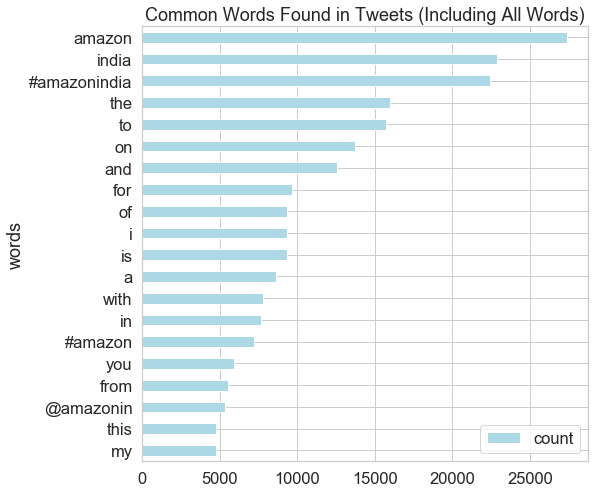

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_no_urls.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="lightblue")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()

In [15]:
#Removing stopwords
stop_words = set(stopwords.words('english'))

In [16]:
data['tweets_nsw'] = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in data['words_in_tweet']]

In [17]:
data.head()

,tweet,Date,cleaned_tweet,words_in_tweet,tweets_nsw
0,logitech prodigy g213 gaming keyboard [50% dis...,2019-01-20,logitech prodigy g213 gaming keyboard [50% dis...,"[logitech, prodigy, g213, gaming, keyboard, [5...","[logitech, prodigy, g213, gaming, keyboard, [5..."
1,can you guys (whoever's reading this) dm @/ama...,2019-01-20,can you guys whoevers reading this dm @amazonh...,"[can, you, guys, whoevers, reading, this, dm, ...","[guys, whoevers, reading, dm, @amazonhelp, ask..."
2,artis e400m in-ear headphones with mic (black)...,2019-01-20,artis e400m inear headphones with mic black [5...,"[artis, e400m, inear, headphones, with, mic, b...","[artis, e400m, inear, headphones, mic, black, ..."
3,@jeffbezos called amazon india to report an in...,2019-01-20,@jeffbezos called amazon india to report an in...,"[@jeffbezos, called, amazon, india, to, report...","[@jeffbezos, called, amazon, india, report, in..."
4,tp-link ha100 nfc-enabled bluetooth music rece...,2019-01-20,tplink ha100 nfcenabled bluetooth music receiv...,"[tplink, ha100, nfcenabled, bluetooth, music, ...","[tplink, ha100, nfcenabled, bluetooth, music, ..."


In [18]:
all_words_nsw = list(itertools.chain(*data['tweets_nsw']))

counts_nsw = collections.Counter(all_words_nsw)


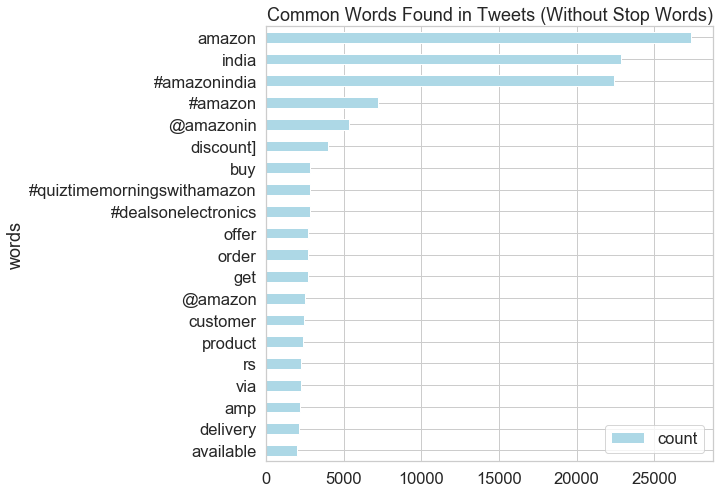

In [19]:
clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(20),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="lightblue")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.show()

## Analysis

#### All the tweets have word amazon
#### In most of the tweet, user have used #amazonindia

In [ ]:

# fig = px.bar(clean_tweets_nsw, x="count", y="words", orientation='h')
# fig.show()

### let's analyze some bigrams

In [20]:
data['terms_bigram'] = [list(bigrams(tweet)) for tweet in data['tweets_nsw']]

In [21]:
data.head()

,tweet,Date,cleaned_tweet,words_in_tweet,tweets_nsw,terms_bigram
0,logitech prodigy g213 gaming keyboard [50% dis...,2019-01-20,logitech prodigy g213 gaming keyboard [50% dis...,"[logitech, prodigy, g213, gaming, keyboard, [5...","[logitech, prodigy, g213, gaming, keyboard, [5...","[(logitech, prodigy), (prodigy, g213), (g213, ..."
1,can you guys (whoever's reading this) dm @/ama...,2019-01-20,can you guys whoevers reading this dm @amazonh...,"[can, you, guys, whoevers, reading, this, dm, ...","[guys, whoevers, reading, dm, @amazonhelp, ask...","[(guys, whoevers), (whoevers, reading), (readi..."
2,artis e400m in-ear headphones with mic (black)...,2019-01-20,artis e400m inear headphones with mic black [5...,"[artis, e400m, inear, headphones, with, mic, b...","[artis, e400m, inear, headphones, mic, black, ...","[(artis, e400m), (e400m, inear), (inear, headp..."
3,@jeffbezos called amazon india to report an in...,2019-01-20,@jeffbezos called amazon india to report an in...,"[@jeffbezos, called, amazon, india, to, report...","[@jeffbezos, called, amazon, india, report, in...","[(@jeffbezos, called), (called, amazon), (amaz..."
4,tp-link ha100 nfc-enabled bluetooth music rece...,2019-01-20,tplink ha100 nfcenabled bluetooth music receiv...,"[tplink, ha100, nfcenabled, bluetooth, music, ...","[tplink, ha100, nfcenabled, bluetooth, music, ...","[(tplink, ha100), (ha100, nfcenabled), (nfcena..."


In [22]:
bigrams = list(itertools.chain(*data['terms_bigram']))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

[(('amazon', 'india'), 19779),
 (('discount]', '#amazonindia'), 3997),
 (('#amazonindia', '#dealsonelectronics'), 2790),
 (('#amazon', '#amazonindia'), 2039),
 (('offer', 'amazon'), 1169),
 (('#amazon', '#india'), 1159),
 (('#amazonindia', '#dealsonpc'), 1153),
 (('#amazonindia', '#amazon'), 1002),
 (('available', 'amazon'), 1000),
 (('via', 'pizzazz'), 882),
 (('pizzazz', 'book'), 860),
 (('book', 'promotions'), 860),
 (('#quiztimemorningswithamazon', '#amazonindia'), 811),
 (('#asmsg', 'bookboost'), 735),
 (('india', 'deal'), 706),
 (('customer', 'service'), 629),
 (('customer', 'care'), 614),
 (('promotions', '#amazonindia'), 563),
 (('#amazongreatindianfestival', '#amazonindia'), 554),
 (('india', 'category'), 505)]

In [23]:
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

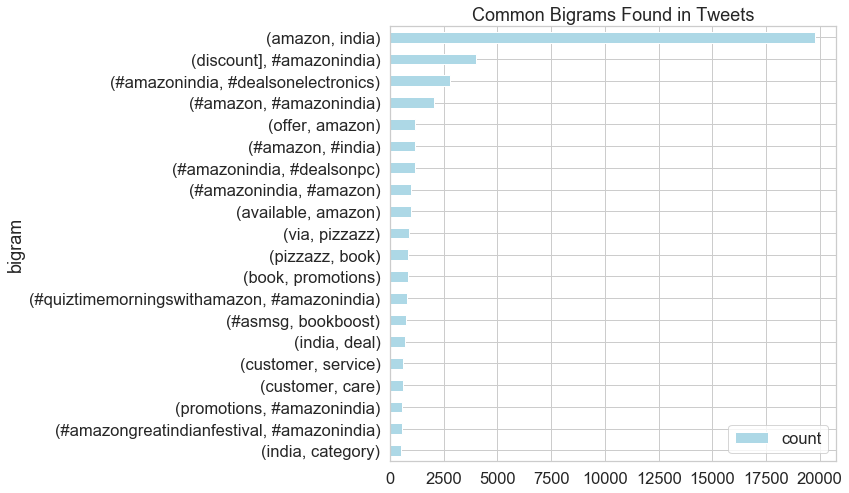

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
bigram_df.sort_values(by='count').plot.barh(x='bigram',
                      y='count',
                      ax=ax,
                      color="lightblue")

ax.set_title("Common Bigrams Found in Tweets")

plt.show()

### Analyzing Tweet Sentiments

In [25]:
data.head()

,tweet,Date,cleaned_tweet,words_in_tweet,tweets_nsw,terms_bigram
0,logitech prodigy g213 gaming keyboard [50% dis...,2019-01-20,logitech prodigy g213 gaming keyboard [50% dis...,"[logitech, prodigy, g213, gaming, keyboard, [5...","[logitech, prodigy, g213, gaming, keyboard, [5...","[(logitech, prodigy), (prodigy, g213), (g213, ..."
1,can you guys (whoever's reading this) dm @/ama...,2019-01-20,can you guys whoevers reading this dm @amazonh...,"[can, you, guys, whoevers, reading, this, dm, ...","[guys, whoevers, reading, dm, @amazonhelp, ask...","[(guys, whoevers), (whoevers, reading), (readi..."
2,artis e400m in-ear headphones with mic (black)...,2019-01-20,artis e400m inear headphones with mic black [5...,"[artis, e400m, inear, headphones, with, mic, b...","[artis, e400m, inear, headphones, mic, black, ...","[(artis, e400m), (e400m, inear), (inear, headp..."
3,@jeffbezos called amazon india to report an in...,2019-01-20,@jeffbezos called amazon india to report an in...,"[@jeffbezos, called, amazon, india, to, report...","[@jeffbezos, called, amazon, india, report, in...","[(@jeffbezos, called), (called, amazon), (amaz..."
4,tp-link ha100 nfc-enabled bluetooth music rece...,2019-01-20,tplink ha100 nfcenabled bluetooth music receiv...,"[tplink, ha100, nfcenabled, bluetooth, music, ...","[tplink, ha100, nfcenabled, bluetooth, music, ...","[(tplink, ha100), (ha100, nfcenabled), (nfcena..."


In [26]:
data['sentiment_objects'] = [TextBlob(tweet) for tweet in data['cleaned_tweet']]

In [27]:
data['sentiment_values'] = [[tweet.sentiment.polarity, str(tweet)] for tweet in data['sentiment_objects']]

In [28]:
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in data['sentiment_objects']]

In [29]:
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

sentiment_df.head()

,polarity,tweet
0,0.000000,logitech prodigy g213 gaming keyboard [50% dis...
1,0.000000,can you guys whoevers reading this dm @amazonh...
2,-0.166667,artis e400m inear headphones with mic black [5...
3,-0.262333,@jeffbezos called amazon india to report an in...
4,0.000000,tplink ha100 nfcenabled bluetooth music receiv...


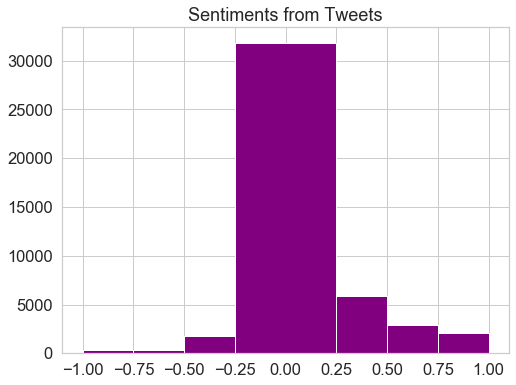

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets")
plt.show()

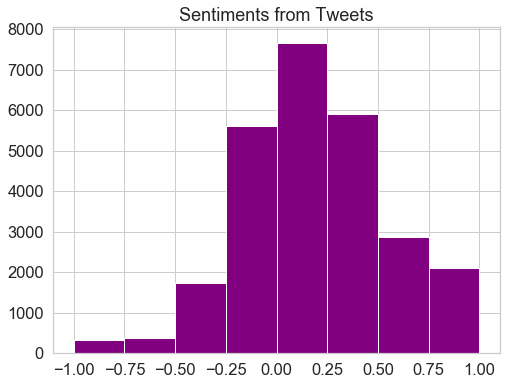

In [31]:
# Remove polarity values equal to zero
sentiment_df = sentiment_df[sentiment_df.polarity != 0]
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets")
plt.show()

### Analysis
#### As the sentiment score is skewed towards positive side, it seems that customer are quite satisfied with amazon

In [32]:
sentiment_df['label'] = ['positive' if x>0 else 'negative' if x<0 else 'neutral' for x in sentiment_df['polarity']]

In [33]:
sentiment_df["label"].value_counts(normalize=True)

positive    0.697741
negative    0.302259
Name: label, dtype: float64

In [34]:
sentiment_df["label"].value_counts()

positive    18532
negative     8028
Name: label, dtype: int64

### Complete Word cloud

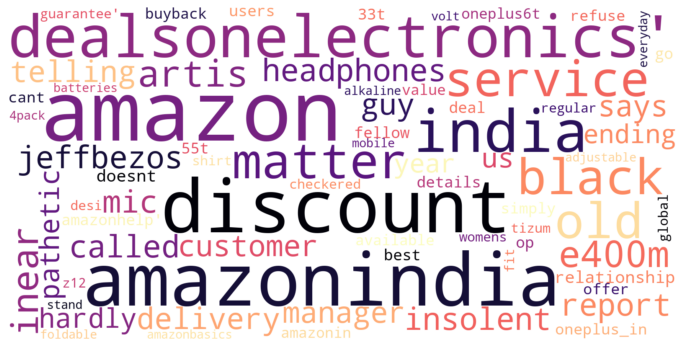

In [35]:
# Word Cloud
from wordcloud import WordCloud

# Read the whole text.
text = sentiment_df['tweet'].values


WC = WordCloud(width=1600, height=800,max_font_size=200, background_color = 'white', colormap='magma',
              max_words = 100).generate(str(text))


# Display the generated image:
plt.figure(figsize=(12,10))
plt.imshow(WC,interpolation="bilinear")
plt.axis("off")
plt.show()

#### Negative tweets

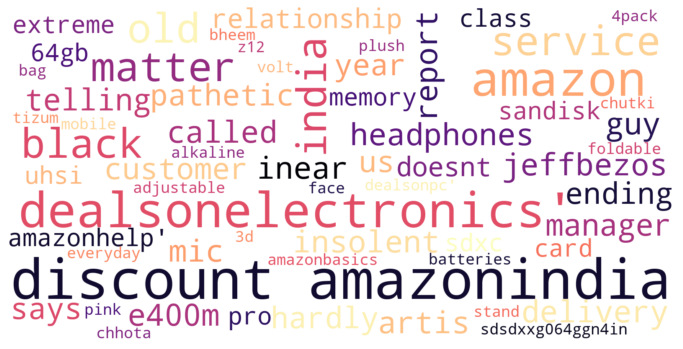

In [36]:
# Word Cloud
from wordcloud import WordCloud

# Read the whole text.
text = sentiment_df[sentiment_df['label']=='negative']['tweet'].values


WC = WordCloud(width=1600, height=800,max_font_size=200, background_color = 'white', colormap='magma',
              max_words = 100).generate(str(text))


# Display the generated image:
plt.figure(figsize=(12,10))
plt.imshow(WC,interpolation="bilinear")
plt.axis("off")
plt.show()

#### Positive tweets

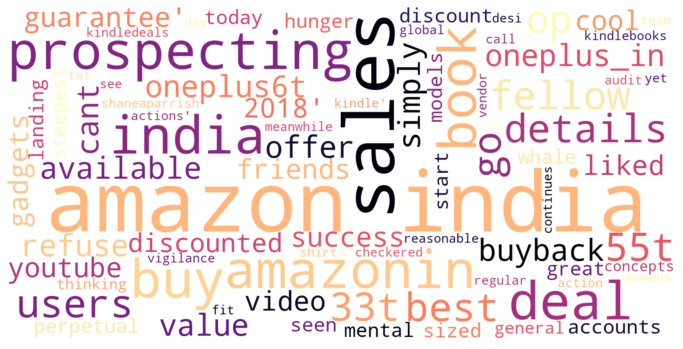

In [37]:
# Word Cloud
from wordcloud import WordCloud

# Read the whole text.
text = sentiment_df[sentiment_df['label']=='positive']['tweet'].values


WC = WordCloud(width=1600, height=800,max_font_size=200, background_color = 'white', colormap='magma',
              max_words = 100).generate(str(text))


# Display the generated image:
plt.figure(figsize=(12,10))
plt.imshow(WC,interpolation="bilinear")
plt.axis("off")
plt.show()

In [38]:
sentiment_df

,polarity,tweet,label
2,-0.166667,artis e400m inear headphones with mic black [5...,negative
3,-0.262333,@jeffbezos called amazon india to report an in...,negative
5,0.466667,my fellow op 33t 55t users best deal for you j...,positive
6,0.475000,i liked a @youtube video 5 cool gadgets you c...,positive
8,-0.125000,sandisk extreme pro 64gb class 10 uhsi sdxc me...,negative
...,...,...,...
45131,0.200000,@amazonin been more than a day and i am yet t...,positive
45133,-0.100000,amazon india chhota bheem chutki 3d face plus...,negative
45137,0.133333,amazon india global desi womens checkered reg...,positive
45138,-0.166667,tizum z12 adjustable foldable mobile stand bla...,negative


In [40]:
data_1 = data.merge(sentiment_df[['label','polarity']],how='left',left_index=True,right_index=True)

### Analyzing sentiments using Vader

In [42]:
analyser = SentimentIntensityAnalyzer()

In [43]:
data.head()

,tweet,Date,cleaned_tweet,words_in_tweet,tweets_nsw,terms_bigram,sentiment_objects,sentiment_values
0,logitech prodigy g213 gaming keyboard [50% dis...,2019-01-20,logitech prodigy g213 gaming keyboard [50% dis...,"[logitech, prodigy, g213, gaming, keyboard, [5...","[logitech, prodigy, g213, gaming, keyboard, [5...","[(logitech, prodigy), (prodigy, g213), (g213, ...","(l, o, g, i, t, e, c, h, , p, r, o, d, i, g, ...","[0.0, logitech prodigy g213 gaming keyboard [5..."
1,can you guys (whoever's reading this) dm @/ama...,2019-01-20,can you guys whoevers reading this dm @amazonh...,"[can, you, guys, whoevers, reading, this, dm, ...","[guys, whoevers, reading, dm, @amazonhelp, ask...","[(guys, whoevers), (whoevers, reading), (readi...","(c, a, n, , y, o, u, , g, u, y, s, , w, h, ...","[0.0, can you guys whoevers reading this dm @a..."
2,artis e400m in-ear headphones with mic (black)...,2019-01-20,artis e400m inear headphones with mic black [5...,"[artis, e400m, inear, headphones, with, mic, b...","[artis, e400m, inear, headphones, mic, black, ...","[(artis, e400m), (e400m, inear), (inear, headp...","(a, r, t, i, s, , e, 4, 0, 0, m, , i, n, e, ...","[-0.16666666666666666, artis e400m inear headp..."
3,@jeffbezos called amazon india to report an in...,2019-01-20,@jeffbezos called amazon india to report an in...,"[@jeffbezos, called, amazon, india, to, report...","[@jeffbezos, called, amazon, india, report, in...","[(@jeffbezos, called), (called, amazon), (amaz...","(@, j, e, f, f, b, e, z, o, s, , c, a, l, l, ...","[-0.2623333333333333, @jeffbezos called amazon..."
4,tp-link ha100 nfc-enabled bluetooth music rece...,2019-01-20,tplink ha100 nfcenabled bluetooth music receiv...,"[tplink, ha100, nfcenabled, bluetooth, music, ...","[tplink, ha100, nfcenabled, bluetooth, music, ...","[(tplink, ha100), (ha100, nfcenabled), (nfcena...","(t, p, l, i, n, k, , h, a, 1, 0, 0, , n, f, ...","[0.0, tplink ha100 nfcenabled bluetooth music ..."


In [44]:
data_vader = data[['Date','cleaned_tweet','tweet']].copy()

In [45]:
data_vader.head()

,Date,cleaned_tweet,tweet
0,2019-01-20,logitech prodigy g213 gaming keyboard [50% dis...,logitech prodigy g213 gaming keyboard [50% dis...
1,2019-01-20,can you guys whoevers reading this dm @amazonh...,can you guys (whoever's reading this) dm @/ama...
2,2019-01-20,artis e400m inear headphones with mic black [5...,artis e400m in-ear headphones with mic (black)...
3,2019-01-20,@jeffbezos called amazon india to report an in...,@jeffbezos called amazon india to report an in...
4,2019-01-20,tplink ha100 nfcenabled bluetooth music receiv...,tp-link ha100 nfc-enabled bluetooth music rece...


In [46]:
data_vader['score'] = [analyser.polarity_scores(x) for x in data_vader['cleaned_tweet']]

In [66]:
data_vader['vader_label'] = [ 'positive' if  x['compound']>0.0 else 'negative' if x['compound']<-0.0 else 'neutral' for x in data_vader['score']]

In [67]:
data_vader.head()


,Date,cleaned_tweet,tweet,score,vader_label
0,2019-01-20,logitech prodigy g213 gaming keyboard [50% dis...,logitech prodigy g213 gaming keyboard [50% dis...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
1,2019-01-20,can you guys whoevers reading this dm @amazonh...,can you guys (whoever's reading this) dm @/ama...,"{'neg': 0.0, 'neu': 0.946, 'pos': 0.054, 'comp...",positive
2,2019-01-20,artis e400m inear headphones with mic black [5...,artis e400m in-ear headphones with mic (black)...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
3,2019-01-20,@jeffbezos called amazon india to report an in...,@jeffbezos called amazon india to report an in...,"{'neg': 0.189, 'neu': 0.779, 'pos': 0.032, 'co...",negative
4,2019-01-20,tplink ha100 nfcenabled bluetooth music receiv...,tp-link ha100 nfc-enabled bluetooth music rece...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral


In [68]:
data_vader['vader_label'].value_counts()

positive    29857
neutral      8461
negative     6826
Name: vader_label, dtype: int64

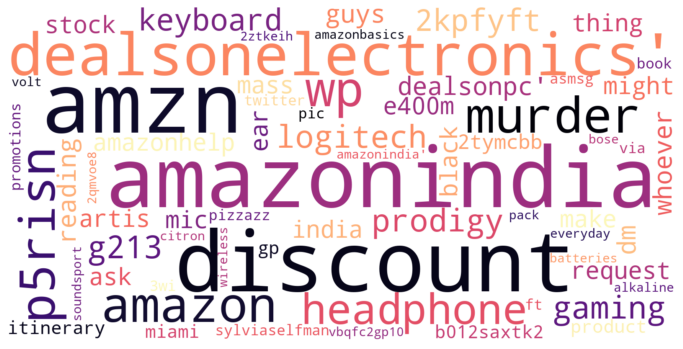

In [69]:
# Word Cloud
from wordcloud import WordCloud

# Read the whole text.
text = data_vader['tweet'].values


WC = WordCloud(width=1600, height=800,max_font_size=200, background_color = 'white', colormap='magma',
              max_words = 100).generate(str(text))


# Display the generated image:
plt.figure(figsize=(12,10))
plt.imshow(WC,interpolation="bilinear")
plt.axis("off")
plt.show()

#### Negative tweets

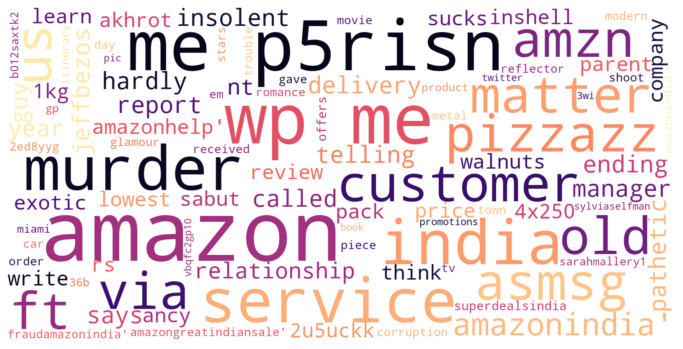

In [70]:
# Word Cloud
from wordcloud import WordCloud

# Read the whole text.
text = data_vader[data_vader['vader_label']=='negative']['tweet'].values


WC = WordCloud(width=1600, height=800,max_font_size=200, background_color = 'white', colormap='magma',
              max_words = 100).generate(str(text))


# Display the generated image:
plt.figure(figsize=(12,10))
plt.imshow(WC,interpolation="bilinear")
plt.axis("off")
plt.show()

#### Positive tweets

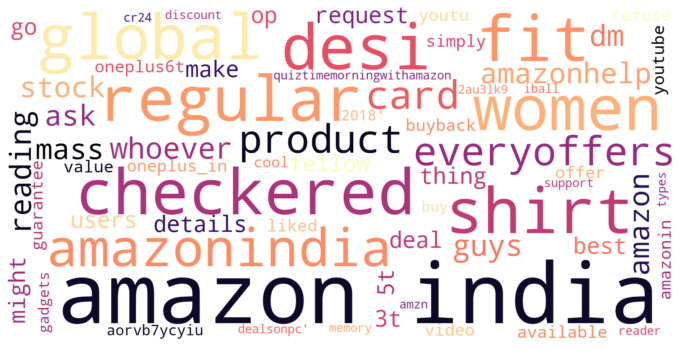

In [71]:
# Word Cloud
from wordcloud import WordCloud

# Read the whole text.
text = data_vader[data_vader['vader_label']=='positive']['tweet'].values


WC = WordCloud(width=1600, height=800,max_font_size=200, background_color = 'white', colormap='magma',
              max_words = 100).generate(str(text))


# Display the generated image:
plt.figure(figsize=(12,10))
plt.imshow(WC,interpolation="bilinear")
plt.axis("off")
plt.show()